In [1]:
import os
import cv2
import random
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import itertools
from sklearn.cluster import MeanShift
from scipy.spatial.distance import cdist

In [2]:
from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew
from matplotlib import pyplot as plt

In [3]:
cv2.setRNGSeed(0)

In [ ]:
def preprocess_img(img,query=False):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgThresh = cv2.ximgproc.niBlackThreshold(img,maxValue=255,type=cv2.THRESH_BINARY,blockSize=5,k=-0.2)
    return imgThresh

#generate_stats components into a dataframe
def generate_stats(totalLabels,stats, centroids):
    '''
    totalLabels,stats, centroids : cv2 connectedComponentsWithStats outputs
    '''
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    return df

#filter 
def filter_cv2_components(df, min_ar_thresh=2, max_ar_thresh=6, min_area=100, max_area=1000,pixel_row_gap = 10):
    '''
    df : dataframe,
    min_ar_thresh : min aspect ratio threshold,
    max_ar_thresh : max aspect ratio threshold,
    pixel_row_gap : min gap b/w pixels to consider them in diift rows
    '''
    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    df = df[(df['aspect_ratio'] > min_ar_thresh) & (df['aspect_ratio'] < max_ar_thresh)]  #filter by aspect-ratio
    df = df[(df['area'] > min_area) & (df['area'] < max_area)]  #filter by area
    df = df.sort_values(by=['top', 'left']).reset_index(drop=True) #sort-by occurence
    
    #calculate rowID, colID
    df['rowID'] = 1
    row_id = 1
    prev_val = df.loc[0, 'top']
    for idx in range(1, df.shape[0]):
        curr_val = df.loc[idx, 'top']
        if curr_val - prev_val > pixel_row_gap:
            row_id += 1
        prev_val = curr_val
        df.at[idx, 'rowID'] = int(row_id)
    df['columnID'] = df.groupby('rowID')['left'].rank().astype(int)
    return df


In [5]:
def build_single_lexicon(label_id, df, k=5):
    '''
    label_id : word component id, 
    df : dataframe
    k : #neighbors to build context
    '''
    if label_id not in df['label_id'].values:
        print("unknown component")
        return
    
    #filter by current component and extract candidate neighbors
    x,y,w,h,r,c = df[df['label_id'] == label_id][['centroid_x','centroid_y','width','height','rowID','columnID']].values[0]
    r1 = (df['rowID'] >= r-1)
    r2 = (df['rowID'] <= r+1)    
    temp_df = df[r1 & r2]
    temp_df = temp_df[temp_df['label_id'] != label_id]
    
    #rotation-invariance - TBD during preprocessing
    
    #scale-invariance
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)/w
    temp_df['new_centroid_y'] = (y-temp_df['centroid_y'])/h
    temp_df['new_left'] = (temp_df['left']-x)/w
    temp_df['new_top'] = (y-temp_df['top'])/h
    temp_df['new_width'] = temp_df['width']/w
    temp_df['new_height'] = temp_df['height']/h
    
    #calculate distance & angle
    temp_df['Euclidean'] = np.sqrt(temp_df['new_centroid_y']**2 + temp_df['new_centroid_x']**2)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0 #heuristic
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0 #heuristic
    temp_df['quadrant'] = pd.cut(temp_df['theta'], 8, labels=range(1,9))
    
    #sort and retreive top-K, format required coordinates.
    res_df = temp_df.sort_values(by=['Euclidean','theta'])[:k] #sort and get top-k neighbors
    res_df = res_df.sort_values(by=['theta'])
    res_df['tl_corner'] = res_df.apply(lambda row: (row['new_left'], row['new_top']), axis=1)
    res_df['br_corner'] = res_df.apply(lambda row: (row['new_left']+row['new_width'], row['new_top']+row['new_height']), axis=1)           
    return res_df


In [6]:
def build_context_layout(img,k_neigh = 5, show_comps=False,query=False):
    '''
    img : image, 
    k_neigh : #neighbors to build context
    '''
    #preprocess and transform image
    img_binarized = preprocess_img(img,query=False)
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(img_binarized,4,cv2.CV_32S)
    df = generate_stats(totalLabels,stats, centroid)
    df = filter_cv2_components(df)
    #print("total no of words(>3 chars) identified:",df.shape[0])
    
    #extract context for each word component
    context_vectors,context_coordinates = [],[]
    for label in df.label_id.values:
        try:
            res = build_single_lexicon(label, df,k=k_neigh)
            if(res.shape[0] >= k_neigh):
                context_vectors.append(res[['tl_corner','br_corner']].values)
                coords = df[df['label_id'] == label][['centroid_x','centroid_y']].values
                context_coordinates.append(coords)
        except Exception as e:
            print(e)
    # format into a set of 4/quadrapules
    flattened_tuples = [np.array([item for sublist in t for item in sublist]) for t in context_vectors]
    array_of_tuples = np.array(flattened_tuples)
    context_vectors = array_of_tuples.reshape(len(context_vectors), k_neigh, 4) # 4 is for (Tl-x,TL-y,BR-x,BR-y )
    context_vectors = context_vectors.round(4)
    #print("total no of contexts extracted:",context_vectors.shape[0])
    
    def plot_components(img, df,comps=[]):
        output = img.copy() 
        for comp in comps:
            x, y, w, h, area = df[df['label_id'] == comp][['left','top','width','height','area']].values[0]
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        plt.imshow(output)
        plt.show()
        print(df.sort_values(by='area'))

    if show_comps:
        plot_components(img, df, df['label_id'].values)
        

    return context_vectors,context_coordinates

In [ ]:
# a,b = build_context_layout(q2,k_neigh = 5)
# a,b = build_context_layout(q12,k_neigh = 5)

In [7]:
class DocumentDetails():
    def __init__(self, img,feature_vectors,label_coordinates, img_path):
        self.img = img
        self.img_path = img_path
        self.feature_vectors = feature_vectors 
        self.label_coordinates = label_coordinates #saves each word coordinates indexed wrt to feature_vectors
        
class DocumentVectors():
    def __init__(self, img_folder_path):
        
        img_files = [file for file in os.listdir(img_folder_path) if file.endswith('.png')] #filter only image files
        img_file_paths = [os.path.join(img_folder_path, file_name) for file_name in img_files] #generate filepaths for all images
        
        #initialize variables
        self.img_file_paths = img_file_paths
        self.docs = {} #save all document details
        self.context_index = {} #save reduced context-vector-layouts index

    #for all images, extract context layouts.
    def extract_context_vectors(self):
        for id,img_path in enumerate(self.img_file_paths):
            img = cv2.imread(img_path)
            feature_vectors,label_coordinates = build_context_layout(img)
            print(img_path,id, img.shape, feature_vectors.shape,len(label_coordinates))
            self.docs[id] = DocumentDetails(img,feature_vectors,label_coordinates, img_path)
    
    #build index from extracted context layouts
    def build_context_index(self, ms=True):
        #build a normal index with ctxlayout->docid pairs
        index = {}
        for id in self.docs:
            cv_all = tuple(self.docs[id].feature_vectors)
            for cv in cv_all:
                index[tuple(list(cv.reshape(-1)))] = id
        print("extracted all context vectors, in total: ",len(index))

        if ms: #if ms is True, then perform Mean shift clustering to reduce index size
            #reduce cl collection with Mean shift clustering
            layouts = list(index.keys())
            clusterer = MeanShift()
            clusters = clusterer.fit(layouts) # type: ignore
            cluster_labels = clusters.labels_
            cluster_centers = clusters.cluster_centers_

            #build new reduced ctxlayout-centre->[list of doc-ids] index
            reduced_index = {}
            for i in range(0,len(cluster_labels)):
                cluster = cluster_labels[i]
                centroid = tuple(cluster_centers[cluster])
                doc = index[layouts[i]]
                if centroid in reduced_index:
                    reduced_index[centroid].add(doc)
                else:
                    reduced_index[centroid] = set([doc])

            self.context_index = reduced_index
            print("built mean-shift reduced-index, in total: ",len(reduced_index))
        else:
            self.context_index = index
            print("built full-index, in total: ",len(index))

    #display all documents in the database
    def show_docs(self):
        for id in self.docs:
            doc = self.docs[id]
            plt.figure(figsize=(6, 4))
            plt.imshow(doc.img)
            plt.title("ID:"+str(id))
            plt.show()     

    #given query img, retreive relevant document

In [8]:
docs_path = './../../data/docs/'


In [9]:
docs_path = './../../data/docs/'
dv = DocumentVectors(docs_path)
print(docs_path)

dv.extract_context_vectors()
dv.build_context_index()

./../../data/docs/
./../../data/docs/5.png 0 (1710, 1296, 3) (441, 5, 4) 441
./../../data/docs/18.png 1 (1674, 1322, 3) (148, 5, 4) 148
./../../data/docs/15.png 2 (1794, 1350, 3) (248, 5, 4) 248
./../../data/docs/10.png 3 (1770, 1270, 3) (229, 5, 4) 229
./../../data/docs/13.png 4 (1780, 1374, 3) (397, 5, 4) 397
./../../data/docs/14.png 5 (1782, 1330, 3) (180, 5, 4) 180
./../../data/docs/11.png 6 (1770, 1338, 3) (393, 5, 4) 393
./../../data/docs/2.png 7 (1694, 1318, 3) (381, 5, 4) 381
./../../data/docs/19.png 8 (1736, 1302, 3) (0, 5, 4) 0
./../../data/docs/3.png 9 (1704, 1300, 3) (395, 5, 4) 395
./../../data/docs/20.png 10 (1774, 1246, 3) (342, 5, 4) 342
./../../data/docs/4.png 11 (1698, 1192, 3) (168, 5, 4) 168
./../../data/docs/1.png 12 (1676, 1264, 3) (345, 5, 4) 345
./../../data/docs/9.png 13 (1658, 1262, 3) (403, 5, 4) 403
./../../data/docs/16.png 14 (1716, 1318, 3) (317, 5, 4) 317
./../../data/docs/31.png 15 (1200, 929, 3) (79, 5, 4) 79
./../../data/docs/17.png 16 (1700, 1190, 3) 

In [ ]:
dv.show_docs()

In [10]:
def random_quarter_crop(img):
    img_width, img_height,_ = img.shape
    max_left = img_width - img_width // 2
    max_top = img_height - img_height // 2
    left = random.randint(0, max_left)
    top = random.randint(0, max_top)
    crop_width = img_width // 2
    crop_height = img_height // 2
    cropped_img = img[left:left + crop_width, top:top + crop_height]
    return cropped_img

./../../data/docs/14.png


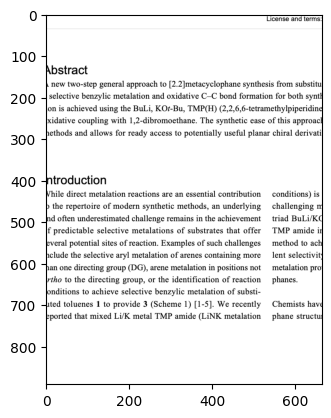

In [11]:
img_id = 14
img_path = docs_path + str(img_id) + '.png'
print(img_path)
img = cv2.imread(img_path)
img_c = random_quarter_crop(img)
plt.imshow(img_c)

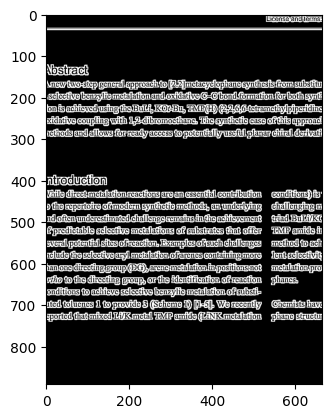

In [12]:
plt.imshow(preprocess_img(img_c),cmap='gray')

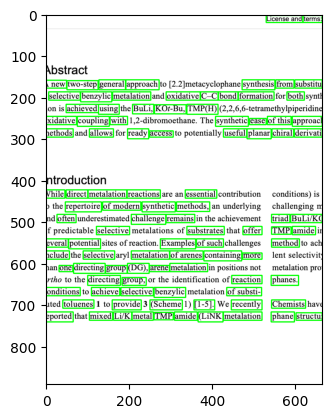

    label_id  left  top  width  height  area  centroid_x  centroid_y  \
70       220    31  605     33      15   308   47.964286  611.779221   
28        82   490  251     40      15   416  509.685096  257.973558   
16        42   580  187     42      20   422  600.954976  197.343602   
1          3   619    3     46      17   441  641.297052   12.022676   
66       207   473  575     47      15   444  496.096847  581.682432   
..       ...   ...  ...    ...     ...   ...         ...         ...   
65       204   380  570     91      24   977  427.370522  581.424770   
11        35   160  187     92      20   991  204.815338  197.919273   
39       115   101  423     93      20   994  146.650905  433.931590   
63       202   205  570     92      20   994  249.706237  580.931590   
94       295   427  717     93      20   994  472.650905  727.931590   

    aspect_ratio  rowID  columnID  
70          2.20     13         1  
28          2.67      5         5  
16          2.10      3    

In [13]:
_ = build_context_layout(img_c, show_comps=True)

In [14]:
def custom_plot_matches2(q, d, m1, m2):
        ''' 
        q: query image,
        d: document image, 
        m1: matched point-set of query ,
        m2: matched point-set of document,
        '''
        point_img = np.full((d.shape[0],d.shape[1]*2,3),255) #draw and image of 2* doc-image
        point_img[:q.shape[0],:q.shape[1],:] = q #fill top-left with query
        point_img[:d.shape[0],d.shape[1]:,:] = d #fill top-right with document
        point_img = point_img.astype('uint8')

        output_image = point_img.copy()
        for match1, match2 in zip(m1, m2):
            #difference between a match should be in range of (mean_centroid-threshold, mean_centroid+threshold)
            (x1, y1) = match1
            (x2, y2) = match2
            x2 = x2+d.shape[1]
            color = (0, 255, 0)
            cv2.circle(output_image, (int(x1),int(y1)), radius=8, color=color, thickness=5)
            cv2.circle(output_image, (int(x2),int(y2)), radius=8, color=color, thickness=5)
            cv2.line(output_image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

        plt.imshow(output_image)
        # plt.savefig("point-matching-image.png")
        plt.show()

In [15]:
#get orientation for a point set.
def get_orientation(matrix):
   '''
   matrix : numpy 2d array
   '''
   determinant = np.linalg.det(matrix)
   orientation = np.sign(determinant) 
   return orientation
#match/verify orientation for 2 point sets.
def verfiy_orientation(P1,P2):
    '''
    P1 : numpy 2d array,
    P2 : numpy 2d array,
    '''
    s1 = get_orientation(P1)
    s2 = get_orientation(P2)
    verif = s1 * s2
    return int(verif)
#triplet-verification
def verification(candidates, query_vectors, query_coordinates, m_matches=30):
        '''
        candidates: candidate doc-id's,
        query_coordinates: geometric coordinates of word components in query img,
        m_matches : no of matched pairs to consider for  verification
        '''
        triplet_scores= {}
        query_coordinates = np.array(query_coordinates).reshape(len(query_coordinates),2).round(2)
        curr_score = -1
        curr_matches = None
        res_path = None
        #for each candidate doc, build triplet score
        for cd in candidates:  
            dc,doc_vectors, path = dv.docs[cd].label_coordinates, dv.docs[cd].feature_vectors, dv.docs[cd].img_path
            doc_coords = np.array(dc).reshape(len(dc),2).round(2)
            doc_vectors = np.array(doc_vectors).reshape(len(doc_vectors),20).round(2)
            #extract pair-wise distances for each cooridinate pair from query, candidate
            distances = np.round(cdist(query_vectors, doc_vectors, metric='euclidean'),2) 
            #build a graph of cooridinate pair from query, candidate with edge-length as distance between them
            edges_dict = {(tuple(query_coordinates[i]), tuple(doc_coords[j])): distances[i, j] for i in range(query_coordinates.shape[0]) for j in range(doc_coords.shape[0])}
            #sort the graph by min edge lengths and extract the matched coordiante pairs from query, candidate
            min_edges = sorted(edges_dict.items(), key=lambda x: x[1])
            print(distances.shape, query_vectors.shape,doc_vectors.shape )

            #extract top m_matches of point-sets of matched items from query, candidate and verify for 1-1 correspondence
            triplets,count = [],1
            p1_set,p2_set = set(),set()
            for edge in min_edges:
                P1,P2,d = edge[0][0],edge[0][1], edge[1]
                if(P1 not in p1_set) and (P2 not in p2_set):
                    p1_set.add(P1)
                    p2_set.add(P2)
                    triplets.append((P1,P2))
                    count += 1
                if count > m_matches:
                    break
            
            #build triplet sets of top m_matches of pairs.
            triplet_combinations = np.array(list(itertools.combinations(triplets, 3)))
            #extract  matche scores for each triplet combination and sum up to make final score
            matches_score = 0
            #for each triplet coordinate-sets, verfiy orientation
            for elm in triplet_combinations:
                s1 = np.concatenate([elm[:,0,:], np.ones((elm[:,0,:].shape[0], 1))], axis=1) #2,3 => 3,3 matrix
                s2 = np.concatenate([elm[:,1,:], np.ones((elm[:,1,:].shape[0], 1))], axis=1) #2,3 => 3,3 matrix
                matches_score += verfiy_orientation(s1,s2) #
            triplet_scores[cd] = matches_score # final triplet matches score for candidate cd
            if(matches_score > curr_score):
                 curr_score = matches_score
                 curr_matches = triplets
                 res_path = path


        print("triplet verification scores:",sorted(triplet_scores.items(), key=lambda x:x[1], reverse=True))

        #sort by matches scores and return top-one.
        results = sorted(triplet_scores, key=triplet_scores.get, reverse=True)
        print("top triplet-score candidates:", results)
        print("final retreived result document ID:", results[0])
        return results[0], curr_matches, res_path
    
    #verify 1-1 point match between a query img and a given doc-id


In [16]:
def query(query_img, max_candidates=10,min_qry_vectors=10):
        '''
        query_img: query img,
        max_candidates: no of candidates for triplet verification
        '''
        #get query-img context layouts
        query_vectors,query_coordinates = build_context_layout(query_img)
        # if len(query_vectors)<min_qry_vectors: #return if <10 query vectors found
        #     print("found only",len(query_vectors),"query vectors. cannot query with this img")
        #     return
        print("found",len(query_vectors),"query vectors")
        query_vectors = query_vectors.reshape(len(query_vectors),20)

        #get matchings-count score
        index = np.array(list(dv.context_index.keys()))
        docs = np.array(list(dv.context_index.values()))
        coverage_scores = {}
        distances = cdist(query_vectors, index) #extract distances between each pair of index-vectors,query-vectors 
        best_match_indices = np.argmin(distances, axis=1) #filter best matches of pairs
        print(best_match_indices,query_vectors.shape, index.shape)
        for bm in best_match_indices: #build coverage scores(no of matched index-vectors) for each document.
            for elm in set(docs[bm]):
                if elm in coverage_scores:
                    coverage_scores[elm] += 1
                else:
                    coverage_scores[elm] = 0
        print("layout coverage scores:",sorted(coverage_scores.items(), key=lambda x:x[1],reverse=True))

        #sort by matchings-count/coverage scores & filter top max_candidates
        candidates = sorted(coverage_scores, key=coverage_scores.get, reverse=True)#[:max_candidates]
        print("top layout-match candidates : ", candidates)
        doc_id, matches, doc_path = verification(candidates, query_vectors, query_coordinates)
        matches = np.array(matches)
        m1 = matches[:,0,:]
        m2 = matches[:,1,:]
        print(doc_path, len(matches))
        
        # point_match(query_img, doc_id)
        doc_img = dv.docs[doc_id].img
        custom_plot_matches2(query_img,doc_img,np.round(m1,2),np.round(m2,2))


ground truth:  14
found 98 query vectors
[19 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 22  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0
  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0] (98, 20) (109, 20)
layout coverage scores: [(1, 97), (2, 97), (11, 97), (13, 97), (14, 97), (19, 97), (20, 97), (15, 96), (17, 96), (4, 95), (7, 95), (9, 95), (10, 95), (12, 95), (16, 95), (18, 95), (0, 94), (3, 94), (5, 94), (6, 94)]
top layout-match candidates :  [1, 2, 11, 13, 14, 19, 20, 15, 17, 4, 7, 9, 10, 12, 16, 18, 0, 3, 5, 6]
(98, 148) (98, 20) (148, 20)
(98, 248) (98, 20) (248, 20)
(98, 168) (98, 20) (168, 20)
(98, 403) (98, 20) (403, 20)
(98, 317) (98, 20) (317, 20)
(98, 345) (98, 20) (345, 20)
(98, 372) (98, 20) (372, 20)
(98, 79) (98, 20) (79, 20)
(98, 114) (98, 20) (114, 20)
(98, 397) (98, 20) (397, 20)
(98, 381) (98, 20) (381, 20)
(98,

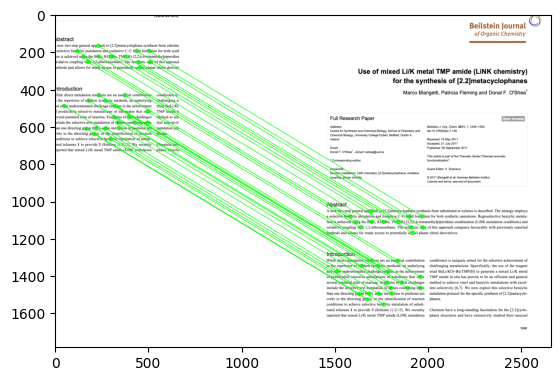

In [17]:
print("ground truth: ", img_id)
query(img_c)

In [18]:
def custom_plot_matches(q, d, m1, m2):
        ''' 
        q: query image,
        d: document image, 
        m1: matched point-set of query ,
        m2: matched point-set of document,
        '''
        point_img = np.full((d.shape[0],d.shape[1]*2,3),255) #draw and image of 2* doc-image
        point_img[:q.shape[0],:q.shape[1],:] = q #fill top-left with query
        point_img[:d.shape[0],d.shape[1]:,:] = d #fill top-right with document
        point_img = point_img.astype('uint8')

        points = abs(m2-m1) #distribution of differences between matched coordinate pairs
        mean_centroid = np.mean(points, axis=0) #mean centroid coordinate difference
        threshold = np.std(points, axis=0) # threshold - std deviation of difference
        
        output_image = point_img.copy()
        for match1, match2 in zip(m1, m2):
            #difference between a match should be in range of (mean_centroid-threshold, mean_centroid+threshold)
            diff = np.round(abs(match2-match1)) 
            c1 = np.all(diff > mean_centroid-threshold)
            c2 = np.all(diff < mean_centroid+threshold)
            (x1, y1) = match1
            (x2, y2) = match2
            x2 = x2+d.shape[1]
            color = (0, 255, 0)
            if(c1 and c2):
                color = (0, 255, 0)
            else:
                color = (255, 0, 0)
            cv2.circle(output_image, (int(x1),int(y1)), radius=8, color=color, thickness=5)
            cv2.circle(output_image, (int(x2),int(y2)), radius=8, color=color, thickness=5)
            cv2.line(output_image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

        plt.imshow(output_image)
        # plt.savefig("point-matching-image.png")
        plt.show()

In [19]:

def point_match(query_img,doc_id):
        '''
        query_img: query img,
        id : doc-id
        '''
        #build context-layout for query_img
        query_vectors,query_coordinates = build_context_layout(query_img)
        doc_vectors,doc_coordinates,doc_img = [],[], None

        #extract context-layout(actual, not reduced index) for doc=id
        for id in dv.docs:
            if(id == doc_id):
                doc_vectors,doc_coordinates,doc_img = dv.docs[id].feature_vectors,dv.docs[id].label_coordinates,dv.docs[id].img
                break

        #for each query vector, find nearest match of context-vector,
        #and then extract corresponding coordinate pairs from query & doc
        matches1,matches2 = [],[]
        for i in range(len(query_vectors)):
            #get min-distance corresponding context layout
            dist = np.linalg.norm(doc_vectors - query_vectors[i, np.newaxis, :, :], axis=(1, 2))
            closest_index = np.argmin(dist)
            query_coords = query_coordinates[i]
            doc_coords = doc_coordinates[closest_index]
            #append matches to return
            matches1.append(query_coords[0])
            matches2.append(doc_coords[0])
        custom_plot_matches(query_img,doc_img,np.round(matches1,2),np.round(matches2,2))

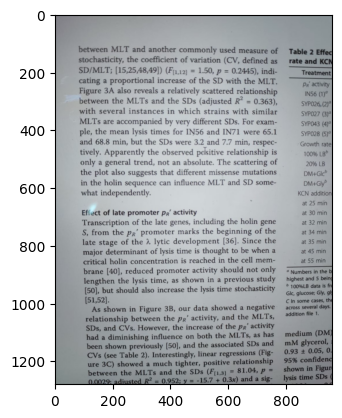

In [20]:
q2 = cv2.imread("./../../data/queries/2.jpeg")
plt.imshow(q2)

In [22]:
print("ground truth: ", 1)
query(q2)

ground truth:  1
found 0 query vectors
[] (0, 20) (109, 20)
layout coverage scores: []
top layout-match candidates :  []
triplet verification scores: []
top triplet-score candidates: []


IndexError: list index out of range

In [ ]:
plt.imshow(preprocess_img(q2,query=True),cmap='gray')

In [ ]:
_ = build_context_layout(q2, show_comps=True,query=True)

In [ ]:
_ = build_context_layout(q2, show_comps=True)

In [ ]:
point_match(query_img=q2, id=5)

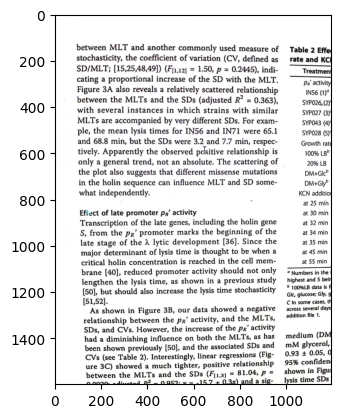

In [23]:
q12 = cv2.imread("./../../data/queries/2_CS.jpeg")
plt.imshow(q12)

In [ ]:
_ = build_context_layout(q12, show_comps=True)

In [24]:
print("ground truth: ", 1)
query(q12)

ground truth:  1
found 0 query vectors
[] (0, 20) (109, 20)
layout coverage scores: []
top layout-match candidates :  []
triplet verification scores: []
top triplet-score candidates: []


IndexError: list index out of range

In [ ]:
point_match(q12, 12)

In [ ]:
point_match(query_img=q12, id=5)

In [ ]:
point_match(query_img=q12, id=0)

In [ ]:
def extract_ROI(image):
    
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(thresh, [c], -1, 0, -1)

    # Dilate to merge into a single contour
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,30))
    dilate = cv2.dilate(thresh, vertical_kernel, iterations=3)

    # Find contours, sort for largest contour and extract ROI
    cnts, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:-1]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        # cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 4)
        ROI = image[y:y+h, x:x+w]
        break
    return ROI
# plt.imshow(extract_ROI(q4))

def deskew(image):
    grayscale = rgb2gray(image)
    angle = determine_skew(grayscale)
    print("angle:", angle)
    rotated = (rotate(image, angle, resize=True) * 255).astype(np.uint8)
    return rotated
# plt.imshow(deskew(extract_ROI(q4)))

def normalize_image(image, target_width=600, target_height=800):
    original_height, original_width = image.shape[:2]
    scale_x = target_width / original_width
    scale_y = target_height / original_height
    scaled_image = cv2.resize(image, (target_width, target_height))
    return scaled_image
# plt.imshow(normalize_image(q4))

In [ ]:
def preprocess_img(img):
    img = extract_ROI(img)
    img = deskew(img)
    img= normalize_image(img)
    return img

In [ ]:
plt.imshow(preprocess_img(q12))

In [ ]:
q22 = preprocess_img(q12)
_ = build_context_layout(q22, show_comps=True)


In [ ]:
query(q22)

In [ ]:
point_match(q22, 12)

In [ ]:
q3 = cv2.imread('./../../data/cam_cap.jpeg')
plt.imshow(q3)

In [ ]:
_ = build_context_layout(q3, show_comps=True)

In [ ]:

q33 = preprocess_img(q3)
plt.imshow(q33)


In [ ]:
_ = build_context_layout(q33, show_comps=True)

In [ ]:
query(q33)

In [ ]:
query_44 = cv2.imread("./../../data/queries/query_31.png")
plt.imshow(query_44)

In [ ]:
_ = build_context_layout(query_44, show_comps=True)

In [ ]:
query(query_44)

In [ ]:
q44 = preprocess_img(query_44)
plt.imshow(q44)

In [ ]:
_ = build_context_layout(q44, show_comps=True)

In [ ]:
query(q44)

In [ ]:
img_c.shape

In [ ]:
gauss_noise=np.zeros((img_c.shape),dtype=np.uint8)
cv2.randn(gauss_noise,128,20)
gauss_noise=(gauss_noise*15).astype(np.uint8)
plt.imshow(gauss_noise,cmap='gray')


In [ ]:
gn_img=cv2.add(img_c,gauss_noise)
plt.imshow(gn_img,cmap='gray')

In [ ]:
_ = build_context_layout(gn_img, show_comps=True)


In [ ]:
query(gn_img)